## My code

In [1]:
# Load packages

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, datasets, models
from torchvision.utils import make_grid

import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
import seaborn as sn
import pandas as pd

import os
from random import shuffle
from shutil import copyfile, copytree

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline

!pip install torchinfo --quiet # Internet On
# !pip install livelossplot --quiet

# from livelossplot import PlotLosses

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset

In [3]:
# Cross validation sets
dataset="dataset-4class"

# classes: "Covid 19" "No finding" "Bacterial Pneumonia" "Viral Pneumonia"

class1="Covid 19" # EDIT
class2="Viral Pneumonia" # EDIT

n_folds=5

files1=os.listdir("../input/" + dataset + "/" + class1)
files2=os.listdir("../input/" + dataset + "/" + class2)
l1=len(files1)
l2=len(files2)
print(l1,l2)

for fold in range(n_folds):
    for folder in ["train","val"]:
        for subfolder in [class1, class2]:
            if not os.path.exists("set" + str(fold+1) + "/" + folder + "/" + subfolder):
                os.makedirs("set" + str(fold+1) + "/" + folder + "/" + subfolder)

kf = KFold(n_splits=n_folds, shuffle=True)

fold=0
for m,n in kf.split(files1):  #train,val
    fold+=1
    for idx in m:
        src= "../input/" + dataset + "/" + class1 + "/" + files1[idx]
        dst= "set" + str(fold) + "/" + "train" + "/" + class1 + "/" + files1[idx]
        copyfile(src,dst)

    for idx in n:
        src= "../input/" + dataset + "/" + class1 + "/" + files1[idx]
        dst= "set" + str(fold) + "/" + "val" + "/" + class1 + "/" + files1[idx]
        copyfile(src,dst)
    
fold=0
for m,n in kf.split(files2):  #train,val
    fold+=1
    for idx in m:
        src= "../input/" + dataset + "/" + class2 + "/" + files2[idx]
        dst= "set" + str(fold) + "/" + "train" + "/" + class2 + "/" + files2[idx]
        copyfile(src,dst)

    for idx in n:
        src= "../input/" + dataset + "/" + class2 + "/" + files2[idx]
        dst= "set" + str(fold) + "/" + "val" + "/" + class2 + "/" + files2[idx]
        copyfile(src,dst)

341 1493


In [4]:
#Sample

data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
# ColorJitter RandomAutocontrast

train_dataset = datasets.ImageFolder(root='set1/train',
                                           transform=data_transform)
train_loader = DataLoader(train_dataset,batch_size=16, shuffle=True,num_workers=4)

val_dataset = datasets.ImageFolder(root='set1/val',
                                           transform=data_transform)
val_loader = DataLoader(val_dataset,batch_size=16, shuffle=True,num_workers=4)

# Print number of samples of each class
from collections import Counter
print(train_dataset.class_to_idx)

print("\nTrain: ",dict(Counter(train_dataset.targets)))
print("Val: ",dict(Counter(val_dataset.targets)))

{'Covid 19': 0, 'Viral Pneumonia': 1}

Train:  {0: 272, 1: 1194}
Val:  {0: 69, 1: 299}


torch.Size([16, 3, 224, 224])
torch.Size([16])


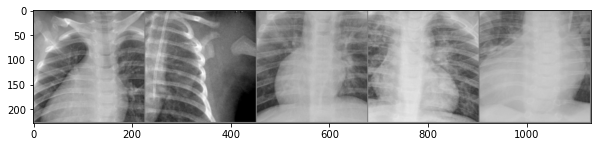

Viral Pneumonia Viral Pneumonia Viral Pneumonia Viral Pneumonia Viral Pneumonia


In [5]:
# Sample images and their labels

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,50))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes=train_dataset.classes

imshow(make_grid(images[0:5]))
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))


# Model

### SE Net: SE module, SE Resnet, SE Inception

In [6]:
# Define the SE module

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# SE Resnet
    
from torch.hub import load_state_dict_from_url
from torchvision.models import ResNet

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SELayer(planes, reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SEBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se = SELayer(planes * 4, reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


def se_resnet18(num_classes=1_000):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    return model


def se_resnet34(num_classes=1_000):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBasicBlock, [3, 4, 6, 3], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    return model


def se_resnet50(num_classes=1_000, pretrained=False):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBottleneck, [3, 4, 6, 3], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    if pretrained:
        model.load_state_dict(load_state_dict_from_url(
            "https://github.com/moskomule/senet.pytorch/releases/download/archive/seresnet50-60a8950a85b2b.pkl"))
    return model


def se_resnet101(num_classes=1_000):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBottleneck, [3, 4, 23, 3], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    return model


def se_resnet152(num_classes=1_000):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBottleneck, [3, 8, 36, 3], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    return model


class CifarSEBasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, reduction=16):
        super(CifarSEBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SELayer(planes, reduction)
        if inplanes != planes:
            self.downsample = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                                            nn.BatchNorm2d(planes))
        else:
            self.downsample = lambda x: x
        self.stride = stride

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        out += residual
        out = self.relu(out)

        return out


class CifarSEResNet(nn.Module):
    def __init__(self, block, n_size, num_classes=10, reduction=16):
        super(CifarSEResNet, self).__init__()
        self.inplane = 16
        self.conv1 = nn.Conv2d(
            3, self.inplane, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplane)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(
            block, 16, blocks=n_size, stride=1, reduction=reduction)
        self.layer2 = self._make_layer(
            block, 32, blocks=n_size, stride=2, reduction=reduction)
        self.layer3 = self._make_layer(
            block, 64, blocks=n_size, stride=2, reduction=reduction)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)
        self.initialize()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride, reduction):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inplane, planes, stride, reduction))
            self.inplane = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


class CifarSEPreActResNet(CifarSEResNet):
    def __init__(self, block, n_size, num_classes=10, reduction=16):
        super(CifarSEPreActResNet, self).__init__(
            block, n_size, num_classes, reduction)
        self.bn1 = nn.BatchNorm2d(self.inplane)
        self.initialize()

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.bn1(x)
        x = self.relu(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)


def se_resnet20(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = CifarSEResNet(CifarSEBasicBlock, 3, **kwargs)
    return model


def se_resnet32(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = CifarSEResNet(CifarSEBasicBlock, 5, **kwargs)
    return model


def se_resnet56(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = CifarSEResNet(CifarSEBasicBlock, 9, **kwargs)
    return model


def se_preactresnet20(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = CifarSEPreActResNet(CifarSEBasicBlock, 3, **kwargs)
    return model


def se_preactresnet32(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = CifarSEPreActResNet(CifarSEBasicBlock, 5, **kwargs)
    return model


def se_preactresnet56(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = CifarSEPreActResNet(CifarSEBasicBlock, 9, **kwargs)
    return model

# SE Inception

from torchvision.models.inception import Inception3


class SEInception3(nn.Module):
    def __init__(self, num_classes, aux_logits=True, transform_input=False):
        super(SEInception3, self).__init__()
        model = Inception3(num_classes=num_classes, aux_logits=aux_logits,
                           transform_input=transform_input)
        model.Mixed_5b.add_module("SELayer", SELayer(192))
        model.Mixed_5c.add_module("SELayer", SELayer(256))
        model.Mixed_5d.add_module("SELayer", SELayer(288))
        model.Mixed_6a.add_module("SELayer", SELayer(288))
        model.Mixed_6b.add_module("SELayer", SELayer(768))
        model.Mixed_6c.add_module("SELayer", SELayer(768))
        model.Mixed_6d.add_module("SELayer", SELayer(768))
        model.Mixed_6e.add_module("SELayer", SELayer(768))
        if aux_logits:
            model.AuxLogits.add_module("SELayer", SELayer(768))
        model.Mixed_7a.add_module("SELayer", SELayer(768))
        model.Mixed_7b.add_module("SELayer", SELayer(1280))
        model.Mixed_7c.add_module("SELayer", SELayer(2048))

        self.model = model

    def forward(self, x):
        _, _, h, w = x.size()
        if (h, w) != (299, 299):
            raise ValueError("input size must be (299, 299)")

        return self.model(x)


def se_inception_v3(**kwargs):
    return SEInception3(**kwargs)

### Model List

In [7]:

def model_select(model_name,num_classes,aux_logits,pretrained):
    
    if(model_name=="scratch"):
        #Model from scratch
        model = nn.Sequential(

            # Conv2D(input channels, output channels, kernel size, padding, stride)
            nn.Conv2d(3,16,kernel_size=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16,32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 3, kernel_size=1),
            nn.Flatten(),
            nn.Linear(in_features=2352, out_features=100, bias=True),
            nn.Linear(in_features=100, out_features=num_classes, bias=True)
        )

    # New
    elif(model_name=="se_resnet18"):
        model = se_resnet18(num_classes=num_classes)
        
    elif(model_name=="se_resnet34"):
        model = se_resnet34(num_classes=num_classes)
    
    elif(model_name=="se_resnet50"):
        model = se_resnet50(num_classes=num_classes,pretrained=pretrained)
        
    elif(model_name=="se_resnet101"):
        model = se_resnet101(num_classes=num_classes)
        
    elif(model_name=="se_resnet152"):
        model = se_resnet152(num_classes=num_classes)
            
    elif(model_name=="se_inception_v3"):
        model = se_inception_v3(num_classes=num_classes,aux_logits=aux_logits)
    
    elif(model_name == "inceptionV3"):
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model = models.inception_v3(pretrained=pretrained)
        # Handle the auxilary net
        num_ftrs = model.AuxLogits.fc.in_features
        model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,num_classes)   
        
    # Resnet family
    elif(model_name=="resnet18"):
        model=models.resnet18(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif(model_name=="resnet34"):
        model=models.resnet34(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif(model_name=="resnet50"):
        model=models.resnet50(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif(model_name=="resnet101"):
        model=models.resnet101(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif(model_name=="resnet152"):
        model=models.resnet152(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif(model_name=="alexnet"):
        model = models.alexnet(pretrained=pretrained)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs,num_classes)

    # Wide Resnet family
    elif(model_name=="wide_resnet50"):
        model=models.wide_resnet50_2(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif(model_name=="wide_resnet101"):
        model=models.wide_resnet101_2(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    # VGG family
    elif(model_name=="vgg11_bn"):
        model = models.vgg11_bn(pretrained=pretrained)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif(model_name=="vgg16_bn"):
        model = models.vgg16_bn(pretrained=pretrained)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif(model_name=="vgg19_bn"):
        model = models.vgg19_bn(pretrained=pretrained)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif(model_name=="squeezenet"):
        model= models.squeezenet1_1(pretrained=pretrained)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

    # Densenet family
    elif(model_name=="densenet121"):
        model= models.densenet121(pretrained=pretrained)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)

    elif(model_name=="densenet169"):
        model= models.densenet169(pretrained=pretrained)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)

    elif(model_name=="densenet201"):
        model= models.densenet201(pretrained=pretrained)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)

    elif(model_name=="densenet161"):
        model= models.densenet161(pretrained=pretrained)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)

    # ResNext family
    elif(model_name=="resnext50"):
        model= models.resnext50_32x4d(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    elif(model_name=="resnext101"):
        model= models.resnext101_32x8d(pretrained=pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)

    else:
        print("Error in model_name")
    
    return model

### Select Model

In [8]:
# Select model
num_classes=2
model_name="resnext101" # EDIT
aux_logits=False
pretrained=True # EDIT

model=model_select(model_name,num_classes,aux_logits,pretrained)


Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [9]:
# Model summary
from torchinfo import summary
summary(model, (32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [32, 256, 56, 56]         16,384
|    |    └─BatchNorm2d: 3-2             [32, 256, 56, 56]         512
|    |    └─ReLU: 3-3                    [32, 256, 56, 56]         --
|    |    └─Conv2d: 3-4                  [32, 256, 56, 56]         18,432
|    |    └─BatchNorm2d: 3-5             [32, 256, 56, 56]         512
|    |    └─ReLU: 3-6                    [32, 256, 56, 56]         --
|    |    └─Conv2d: 3-7                  [32, 256, 56, 56]         65,5

### Helper functions: Early Stopping

In [10]:
# Early stopping
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)


## Training + Validation

In [11]:
# Training Parameters

num_epochs=50 # EDIT

# Loss fn
weights = [5.0, 1.0] # classes are acc. to alphabetical order # EDIT
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)


Train loss: 0.1991 	 Val loss: 0.0606 	 Train acc.: 0.9195 	 Val acc.: 0.9755
Epoch: 1 	 LR: 1.00e-04 	Epoch time: 60.26 s
Fold: 1 	Fold time: 62.25 s 	Total time: 62.25 s

Train loss: 0.1139 	 Val loss: 0.1106 	 Train acc.: 0.9611 	 Val acc.: 0.9321
Epoch: 2 	 LR: 1.00e-04 	Epoch time: 61.13 s
Fold: 1 	Fold time: 123.39 s 	Total time: 123.39 s

Train loss: 0.0841 	 Val loss: 0.0552 	 Train acc.: 0.9707 	 Val acc.: 0.9755
Epoch: 3 	 LR: 1.00e-04 	Epoch time: 61.53 s
Fold: 1 	Fold time: 184.92 s 	Total time: 184.92 s

Train loss: 0.0932 	 Val loss: 0.1237 	 Train acc.: 0.9638 	 Val acc.: 0.9239
Epoch: 4 	 LR: 1.00e-04 	Epoch time: 61.96 s
Fold: 1 	Fold time: 246.87 s 	Total time: 246.88 s

Train loss: 0.1370 	 Val loss: 0.0759 	 Train acc.: 0.9618 	 Val acc.: 0.9647
Epoch: 5 	 LR: 1.00e-04 	Epoch time: 61.35 s
Fold: 1 	Fold time: 308.23 s 	Total time: 308.23 s

Train loss: 0.0479 	 Val loss: 0.0277 	 Train acc.: 0.9829 	 Val acc.: 0.9891
Epoch: 6 	 LR: 1.00e-04 	Epoch time: 62.17 s
Fol

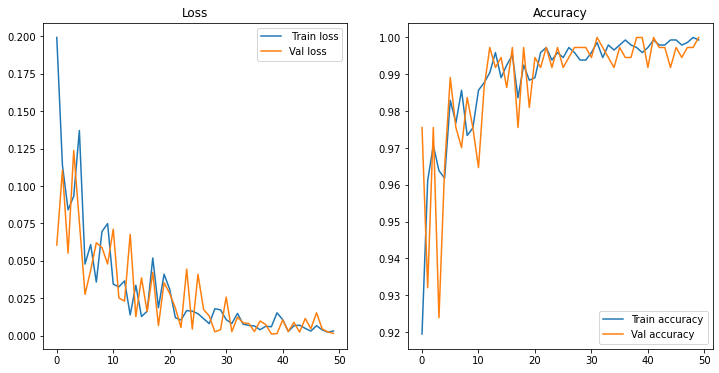


Fold: 1 	 Accuracy: 100.0000

Train loss: 0.2069 	 Val loss: 0.0508 	 Train acc.: 0.9284 	 Val acc.: 0.9755
Epoch: 1 	 LR: 1.00e-04 	Epoch time: 62.74 s
Fold: 2 	Fold time: 64.56 s 	Total time: 3110.74 s

Train loss: 0.1266 	 Val loss: 0.0629 	 Train acc.: 0.9523 	 Val acc.: 0.9728
Epoch: 2 	 LR: 1.00e-04 	Epoch time: 61.68 s
Fold: 2 	Fold time: 126.24 s 	Total time: 3172.42 s

Train loss: 0.1027 	 Val loss: 0.0496 	 Train acc.: 0.9700 	 Val acc.: 0.9700
Epoch: 3 	 LR: 1.00e-04 	Epoch time: 61.44 s
Fold: 2 	Fold time: 187.68 s 	Total time: 3233.86 s

Train loss: 0.0797 	 Val loss: 0.0687 	 Train acc.: 0.9680 	 Val acc.: 0.9728
Epoch: 4 	 LR: 1.00e-04 	Epoch time: 61.09 s
Fold: 2 	Fold time: 248.77 s 	Total time: 3294.96 s

Train loss: 0.0594 	 Val loss: 0.0602 	 Train acc.: 0.9836 	 Val acc.: 0.9728
Epoch: 5 	 LR: 1.00e-04 	Epoch time: 60.94 s
Fold: 2 	Fold time: 309.71 s 	Total time: 3355.90 s

Train loss: 0.0666 	 Val loss: 0.0708 	 Train acc.: 0.9768 	 Val acc.: 0.9646
Epoch: 6 	 L

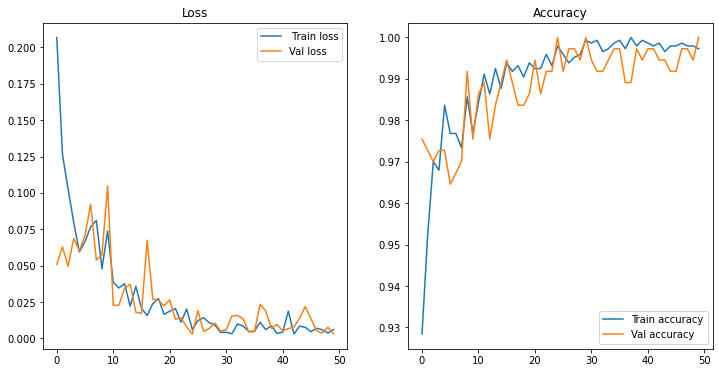


Fold: 2 	 Accuracy: 99.7275

Train loss: 0.1843 	 Val loss: 0.0749 	 Train acc.: 0.9250 	 Val acc.: 0.9809
Epoch: 1 	 LR: 1.00e-04 	Epoch time: 61.24 s
Fold: 3 	Fold time: 63.02 s 	Total time: 6193.40 s

Train loss: 0.1297 	 Val loss: 0.0422 	 Train acc.: 0.9564 	 Val acc.: 0.9782
Epoch: 2 	 LR: 1.00e-04 	Epoch time: 63.09 s
Fold: 3 	Fold time: 126.11 s 	Total time: 6256.49 s

Train loss: 0.1350 	 Val loss: 0.0293 	 Train acc.: 0.9550 	 Val acc.: 0.9891
Epoch: 3 	 LR: 1.00e-04 	Epoch time: 61.96 s
Fold: 3 	Fold time: 188.07 s 	Total time: 6318.45 s

Train loss: 0.0907 	 Val loss: 0.0709 	 Train acc.: 0.9707 	 Val acc.: 0.9755
Epoch: 4 	 LR: 1.00e-04 	Epoch time: 61.75 s
Fold: 3 	Fold time: 249.82 s 	Total time: 6380.20 s

Train loss: 0.1012 	 Val loss: 0.0187 	 Train acc.: 0.9680 	 Val acc.: 1.0000
Epoch: 5 	 LR: 1.00e-04 	Epoch time: 63.14 s
Fold: 3 	Fold time: 312.96 s 	Total time: 6443.35 s

Train loss: 0.0884 	 Val loss: 0.0263 	 Train acc.: 0.9721 	 Val acc.: 0.9837
Epoch: 6 	 LR

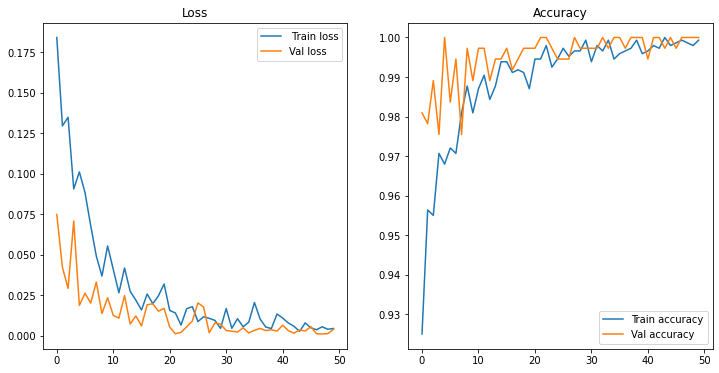


Fold: 3 	 Accuracy: 100.0000

Train loss: 0.2196 	 Val loss: 0.1639 	 Train acc.: 0.9189 	 Val acc.: 0.9372
Epoch: 1 	 LR: 1.00e-04 	Epoch time: 60.70 s
Fold: 4 	Fold time: 62.74 s 	Total time: 9314.40 s

Train loss: 0.1344 	 Val loss: 0.0471 	 Train acc.: 0.9564 	 Val acc.: 0.9809
Epoch: 2 	 LR: 1.00e-04 	Epoch time: 60.32 s
Fold: 4 	Fold time: 123.06 s 	Total time: 9374.72 s

Train loss: 0.1287 	 Val loss: 0.0377 	 Train acc.: 0.9503 	 Val acc.: 0.9973
Epoch: 3 	 LR: 1.00e-04 	Epoch time: 59.56 s
Fold: 4 	Fold time: 182.63 s 	Total time: 9434.28 s

Train loss: 0.0844 	 Val loss: 0.0630 	 Train acc.: 0.9680 	 Val acc.: 0.9645
Epoch: 4 	 LR: 1.00e-04 	Epoch time: 59.80 s
Fold: 4 	Fold time: 242.42 s 	Total time: 9494.08 s

Train loss: 0.0782 	 Val loss: 0.0328 	 Train acc.: 0.9673 	 Val acc.: 0.9836
Epoch: 5 	 LR: 1.00e-04 	Epoch time: 60.32 s
Fold: 4 	Fold time: 302.75 s 	Total time: 9554.40 s

Train loss: 0.0933 	 Val loss: 0.0359 	 Train acc.: 0.9700 	 Val acc.: 0.9836
Epoch: 6 	 L

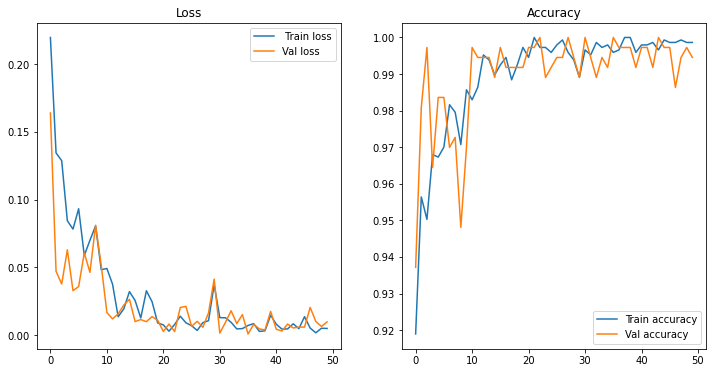


Fold: 4 	 Accuracy: 100.0000

Train loss: 0.1855 	 Val loss: 0.1274 	 Train acc.: 0.9257 	 Val acc.: 0.9754
Epoch: 1 	 LR: 1.00e-04 	Epoch time: 61.27 s
Fold: 5 	Fold time: 63.54 s 	Total time: 12346.35 s

Train loss: 0.1048 	 Val loss: 0.0809 	 Train acc.: 0.9721 	 Val acc.: 0.9754
Epoch: 2 	 LR: 1.00e-04 	Epoch time: 62.09 s
Fold: 5 	Fold time: 125.64 s 	Total time: 12408.44 s

Train loss: 0.0790 	 Val loss: 0.1650 	 Train acc.: 0.9707 	 Val acc.: 0.9699
Epoch: 3 	 LR: 1.00e-04 	Epoch time: 61.97 s
Fold: 5 	Fold time: 187.60 s 	Total time: 12470.41 s

Train loss: 0.1472 	 Val loss: 0.0549 	 Train acc.: 0.9455 	 Val acc.: 0.9863
Epoch: 4 	 LR: 1.00e-04 	Epoch time: 61.81 s
Fold: 5 	Fold time: 249.41 s 	Total time: 12532.22 s

Train loss: 0.0806 	 Val loss: 0.0442 	 Train acc.: 0.9673 	 Val acc.: 0.9863
Epoch: 5 	 LR: 1.00e-04 	Epoch time: 62.11 s
Fold: 5 	Fold time: 311.53 s 	Total time: 12594.33 s

Train loss: 0.0835 	 Val loss: 0.1780 	 Train acc.: 0.9714 	 Val acc.: 0.9235
Epoch: 

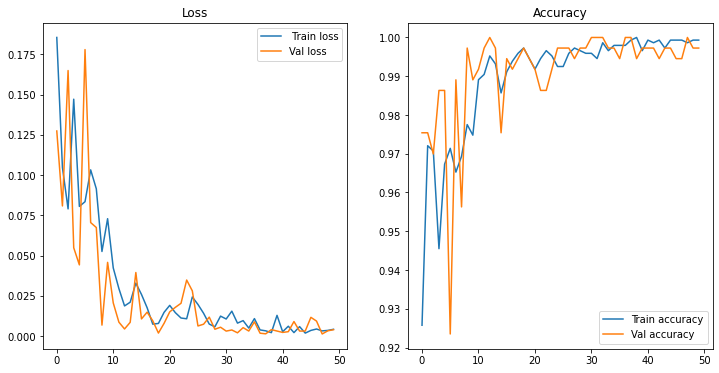


Fold: 5 	 Accuracy: 99.7268

Model name:  resnext101


In [12]:
# Training + Validation + Testing

t0=time.time()
# groups = {'Accuracy': ['accuracy', 'val_accuracy'], 'Loss': ['loss', 'val_loss']}
# liveloss = PlotLosses(groups=groups)
logs={}
op={}

for fold in range(n_folds):
    t1=time.time()
    
    # Load data
    train_dataset = datasets.ImageFolder(root='set' + str(fold+1) + '/train',transform=data_transform)
    train_loader = DataLoader(train_dataset,batch_size=16, shuffle=True,num_workers=4)
    val_dataset = datasets.ImageFolder(root='set'  + str(fold+1) +  '/val',transform=data_transform)
    val_loader = DataLoader(val_dataset,batch_size=16, shuffle=True,num_workers=4)

    model=model_select(model_name,num_classes,aux_logits,pretrained)
    model = model.to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-4) # EDIT

    # LR scheduler: Decays the learning rate of each parameter group by gamma every step_size epochs 
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # EDIT

    # Early stopping: patience: Number of epochs with no improvement after which training will be stopped
    es = EarlyStopping(patience = 25) # EDIT

    logs[ str(fold+1) + "_" + "train_loss"] = []
    logs[ str(fold+1) + "_" + "train_accuracy"] = []
    logs[ str(fold+1) + "_" + "val_loss"] = []
    logs[ str(fold+1) + "_" + "val_accuracy"] = []
    op[ str(fold+1) + "_" + "y"]=[]
    op[ str(fold+1) + "_" + "yhat"]=[]
    
    for epoch in range(num_epochs):
        t2=time.time()

        # Training
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            if aux_logits: 
                # Inception models have two losses during training
                outputs, aux_outputs = model(inputs)
                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4*loss2

            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = (running_loss / len(train_loader.dataset))
        train_accuracy = (running_corrects.float() / len(train_loader.dataset))
        logs[ str(fold+1) + "_" + "train_loss"].append(train_loss.item())
        logs[ str(fold+1) + "_" + "train_accuracy"].append(train_accuracy.item())

        scheduler.step() # LR scheduler

        # Validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        val_loss = (running_loss / len(val_loader.dataset))
        val_accuracy = (running_corrects.float() / len(val_loader.dataset))
        logs[ str(fold+1) + "_" + "val_loss"].append(val_loss.item())
        logs[ str(fold+1) + "_" + "val_accuracy"].append(val_accuracy.item())

        if es.step(val_loss): # Early stopping by monitoring val_loss
            break

    #     liveloss.update(logs)
    #     liveloss.send()

        print("\nTrain loss: {:.4f} \t Val loss: {:.4f} \t Train acc.: {:.4f} \t Val acc.: {:.4f}"
              .format(train_loss.item(),val_loss.item(),train_accuracy.item(),val_accuracy.item()))

        print('Epoch: {} \t LR: {:.2e} \tEpoch time: {:.2f} s'
                .format(epoch+1,optimizer.param_groups[0]['lr'],time.time()- t2))
        
        print("Fold: {} \t" "Fold time: {:.2f} s \tTotal time: {:.2f} s"
                 .format(fold+1,time.time()-t1,time.time()-t0))
        
    # Plot
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.plot(logs[ str(fold+1) + "_" + "train_loss"])
    plt.plot(logs[ str(fold+1) + "_" + "val_loss"])
    plt.legend([" Train loss", "Val loss"])
    plt.title("Loss")
    plt.subplot(122)
    plt.plot(logs[ str(fold+1) + "_" + "train_accuracy"])
    plt.plot(logs[ str(fold+1) + "_" + "val_accuracy"])
    plt.legend(["Train accuracy","Val accuracy"])
    plt.title("Accuracy")
    plt.show()
    
    # Testing
    correct = 0
    total = 0
    yhat=[]
    y=[]
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y.append(labels.tolist())
            yhat.append(predicted.tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print("\nFold: {} \t Accuracy: {:.4f}" .format(str(fold+1),100 * correct / total))
    
    # Get y,yhat as list
    op[ str(fold+1) + "_" + "y"]=[item for sublist in y for item in sublist]
    op[ str(fold+1) + "_" + "yhat"]=[item for sublist in yhat for item in sublist]

print("\nModel name: ",model_name)

## Performance Metrics

In [13]:
class_names = val_dataset.classes

metrics={}
metrics["acc"]=[]

for c in [class1, class2, "weighted avg"]:
    metrics[c]={}
    for m in ["precision","recall","f1-score"]:
        metrics[c][m]=[]

for fold in range(n_folds):
    y=op[ str(fold+1) + "_" + "y"]
    yhat=op[ str(fold+1) + "_" + "yhat"]
    
    # Print confusion matrix
#     cm=confusion_matrix(y,yhat)
#     print(cm)

    # Print metrics
#     cm_report=classification_report(y, yhat, target_names=class_names, digits=4)
#     print(cm_report)
    
    cm_dict=classification_report(y,yhat, target_names=class_names, digits=4, output_dict=True)
    metrics["acc"].append(cm_dict["accuracy"])
    for c in [class1, class2,"weighted avg"]:
        for m in ["precision","recall","f1-score"]:
            metrics[c][m].append(cm_dict[c][m])

print("\nMean performance: ")
print("\nAccuracy: {:.4f}".format(np.mean(metrics["acc"])))
for c in [class1, class2, "weighted avg"]:
    print(c)
    for m in ["precision","recall","f1-score"]:
        print("\t",m,": {:.4f}".format(np.mean(metrics[c][m])))
        
print("\nModel Name: {}".format(model_name))


Mean performance: 

Accuracy: 0.9989
Covid 19
	 precision : 0.9942
	 recall : 1.0000
	 f1-score : 0.9971
Viral Pneumonia
	 precision : 1.0000
	 recall : 0.9987
	 f1-score : 0.9993
weighted avg
	 precision : 0.9989
	 recall : 0.9989
	 f1-score : 0.9989

Model Name: resnext101


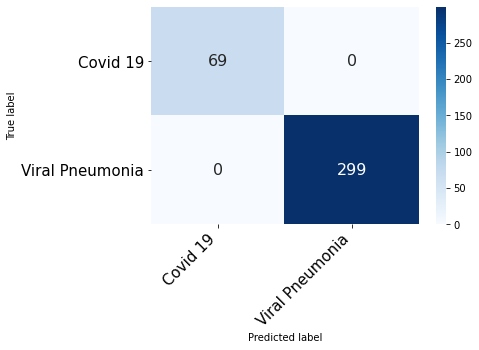

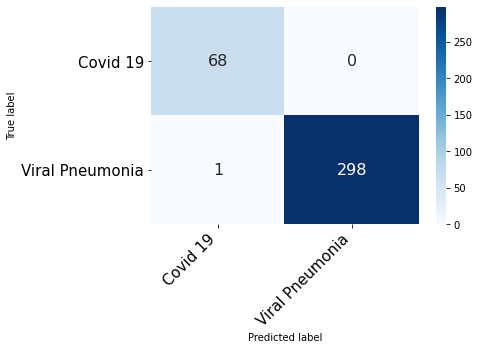

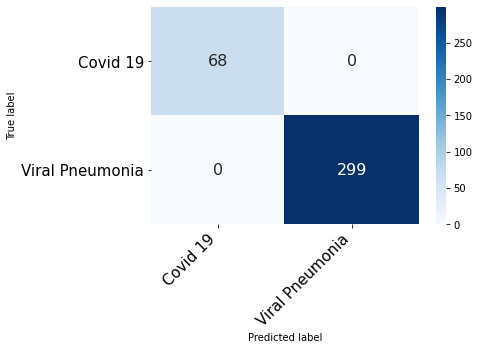

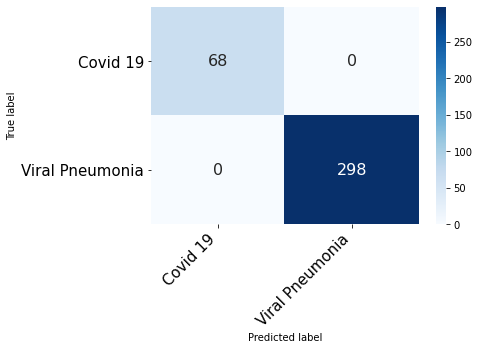

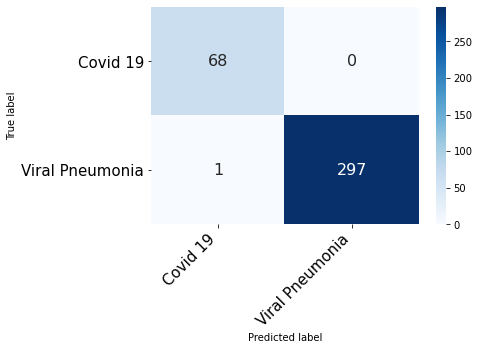

In [14]:
for fold in range(n_folds):
    y=op[ str(fold+1) + "_" + "y"]
    yhat=op[ str(fold+1) + "_" + "yhat"]
    
    # Print confusion matrix
    cm=confusion_matrix(y,yhat)
#     print(cm)
    
    # Enhanced confusion matrix
    plt.figure(figsize=(6,4))

    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names).astype(int)
    heatmap = sn.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={'size':16})

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Sample predictions



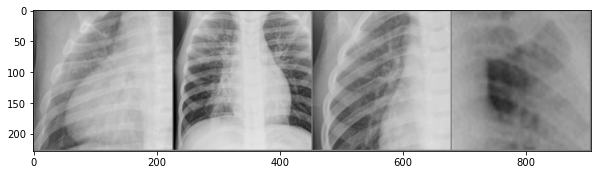

GroundTruth:  Viral Pneumonia Viral Pneumonia Viral Pneumonia Covid 19
Predicted:  Viral Pneumonia Viral Pneumonia Viral Pneumonia Covid 19


In [15]:
# Testing a few samples
dataiter = iter(val_loader)
images, labels = dataiter.next()

# print images
print("Sample predictions\n")
imshow(make_grid(images[0:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

images=images.to(device)
outputs=model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [16]:
# # Save model
# #date-time,model name, pretrained=True or False
# PATH="/kaggle/working/{}_{}.pth".format(time.strftime("%Y%m%d-%H%M%S"),model_name)
# torch.save(model.state_dict(), PATH)